In [1]:
%matplotlib inline

__Mapping Visium's v1 spots onto a whole-slide image__
-

[10X Genomics' Visium (v1) platform](https://www.10xgenomics.com/products/visium-v1-gene-expression) for spatial transcriptomics is optimized for fresh frozen material and allows
profiling 4 tissue regions in a single slide. Each region has an area of 42.25mm<sup>2</sup> (= 6.5mm x 6.5mm), and a snapshot is saved in a so-called "high-resolution" image which accompanies the gene expression
(counts) matrix. Onto the tissue region, a regular mesh of spots is overlaid, and gene expression is measured from each individual spot.
The spot coordinates are relative to the "high resolution" image. For image analysis however, the "high-resolution" image is not enough and one should use, if possible,
a scanned whole slide image.

Here we are concerned with mapping the spot coordinates from Visium's data set onto a whole slide image. This notebook is designed to deal with the case of
["gene expression slide"](cdn.10xgenomics.com/image/upload/v1695772295/support-documents/CG000241_VisiumImagingGuidelinesTN_RevE.pdf) in which 4 square regions with exterior size of
8mm are used to frame the tissue samples. The frame (fiducial frame) is made of specific patterns of (fiducial) points that should facilitate the estimation of the affine
transformation from "high resolution" image space to whole slide image.

In the following, a number of assumptions are made:

- There is a whole slide image (WSI) of the expression slide, with all 4 regions clearlly visible. Ideally, the WSI has been scanned at 40x or 20x. In any case, the format of the image should be compatible with [OpenSlide](https://openslide.org/) to allow processing.
- Each region is represented by a "high resolution" image (as produced by Visium, __called `hires_image.png`__) and 3 specific files (.feather format) containing: the spots coordinates (__`spots.feather`__), expression profile for each spot (__`expression.feather`__), and gene annotation (__`genes.feather`__), respectively.

In [2]:
try:
    import cv2
    cv2.setNumThreads(16)
    import numpy as np
    import itertools
    import matplotlib.pyplot as plt
    import math
    import pandas as pd
    from skimage.measure import label, regionprops
    from skimage.draw import disk as draw_disk
    from skimage.draw import circle_perimeter
    from skimage.exposure import match_histograms
    from skimage.metrics import structural_similarity
    from skimage.util import img_as_float32, img_as_ubyte, img_as_uint
    import orjson as json
    import collections
    from pathlib import Path
    from compass.core import WSI, Px, wsi2hdf5, MRI
    from compass.sample import SampleManager
    import wsitk_annot
    from typing import Union
    import json as pyjson
    import SimpleITK as sitk
except SyntaxWarning(wrn):
    pass  # SyntaxWarning: invalid escape sequence '\|' etc from Mahotas
    

Local functions for registration:

In [3]:
def get_binary_spots(img):
    # process img to get the spots (features) as white objects on black background
    _, im_bin = cv2.threshold(
        img,
        0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )  # features are darker, make them white at the end
    im_bin_tmp = im_bin.copy()
    h, w = im_bin.shape[:2]  # nrows, ncols
    mask = np.zeros((h + 2, w + 2), np.uint8)
    cv2.floodFill(im_bin_tmp, mask, (0, 0), 255)
    im_bin_tmp = cv2.bitwise_not(im_bin_tmp)
    return im_bin | im_bin_tmp


def get_properties(binary_img: np.array) -> tuple:
    lb = label(binary_img, background=0)
    pp = regionprops(lb)
    return [
        {
            'area': p.area,
            'centroid': p.centroid,
            'circ': 4 * np.pi * p.area / p.perimeter ** 2 if p.perimeter > 0 else np.inf,
            'label': p.label,
            'radii': (p.axis_major_length / 2, p.axis_minor_length / 2),
            'rr': p.axis_minor_length / p.axis_major_length if p.axis_major_length > 0 else np.inf,
        }
        for p in pp
    ], lb


# keep only the most probable spots: circular, not too small
def filter_spots(binary_img, lb_img, props, min_area=300, min_circ=0.85, min_rr=0.9) -> tuple:
    pp = []

    for p in props:
        if p['area'] < min_area or \
                p['circ'] < min_circ or \
                p['rr'] < min_rr:
            # erase the object
            binary_img[lb_img == p['label']] = 0
        else:
            pp.append(p)

    return binary_img, pp


def synthetic_spots(shape: tuple, props: list) -> tuple:
    # create a binary image of shape <shape> with spots placed at the
    # centroids of objects in <props>, all having the radius the median
    # of the radii in <props>
    img = np.zeros(shape, dtype=np.uint8)
    r = [0.5 * (p['radii'][0] + p['radii'][1]) for p in props]
    r = np.median(r)

    for p in props:
        [rr, cc] = draw_disk((int(p['centroid'][0]), int(p['centroid'][1])), r, shape=shape)
        img[rr, cc] = 255

    return img, r


def match_patch(tmpl: np.ndarray, img: np.ndarray,
                angles: np.ndarray = np.linspace(0, 360, 37),
                scales: np.ndarray = np.linspace(0.8, 1.2, 9)) -> dict:
    """Find a template image within a larger image using template matching with rotation and scaling.

    Args:
        tmpl: Template image (grayscale) to search for
        img: Larger image (grayscale) to search within
        angles: Array of rotation angles in degrees to test (default: 37 angles from 0 to 360)
        scales: Array of scaling factors to test (default: 9 values from 0.8 to 1.2)

    Returns:
        dict: Dictionary containing best match information with keys:
            - 'score': Correlation coefficient (-1 to 1)
            - 'angle': Best rotation angle in degrees
            - 'scale': Best scaling factor
            - 'loc': (x,y) tuple of top-left corner position in img
    """

    best = {'score': -1.0, 'angle': None, 'scale': None, 'loc': None, 'tmpl': None}

    for scale in scales:
        if np.isnan(scale):
            continue
        # resize template
        sz = (int(tmpl.shape[1] * scale), int(tmpl.shape[0] * scale))
        if sz[0] < 4 or sz[1] < 4:  # too small to match
            continue
        scaled = cv2.resize(tmpl, sz, interpolation=cv2.INTER_LINEAR)

        for angle in angles:
            # rotate about its center
            M = cv2.getRotationMatrix2D((sz[0] / 2, sz[1] / 2), angle, 1.0)
            rot = cv2.warpAffine(scaled, M, sz,
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REPLICATE)

            # template match
            res = cv2.matchTemplate(img, rot, cv2.TM_CCOEFF_NORMED)
            _, score, _, loc = cv2.minMaxLoc(res)

            if score > best['score']:
                best.update({
                    'score': score,
                    'angle': angle,
                    'scale': scale,
                    'loc': loc,  # top-left corner in img
                    'tmpl': rot
                })
    return best  # best transformation

def get_corners(img: np.ndarray, n_segm: int = 6) -> dict:
    """Get corners of the image using template matching.

    Args:
        img: Image to find corners in
        n_segm: Number of segments to divide the image into for corner detection

    Returns:
        dict: Dictionary with corner positions and templates
    """
    h, w = img.shape[:2]
    hs = h // n_segm
    ws = w // n_segm

    corners = {
        'TL': img[0: hs, 0: ws, ...],
        'TR': img[0: hs, w - ws: w, ...],
        'BL': img[h - hs: h, 0: ws, ...],
        'BR': img[h - hs: h, w - ws: w, ...]
    }
    proc_corners = {}
    for side in ['TL', 'TR', 'BL', 'BR']:
        bin_img = get_binary_spots(corners[side])
        pp, lb = get_properties(bin_img)
        bin_img, pp = filter_spots(bin_img, lb, pp)
        proc_corners[side], r = synthetic_spots(bin_img.shape, pp)
        proc_corners[side + '_spot_size'] = r

    return proc_corners

def match_templates_to_corners(templ: dict, corners: dict, k_list: list=('BL', 'BR', 'TR', 'TL')) -> dict:
    # Normally, templ contains templates for 4 corners (labelled 'BL', ...) and corners contains
    # regions of the target image corresponding to the corners (still labelled 'BL', ...) that
    # are put in correspondence with the template. The function returns the mapping from template
    # corners to image corners and the associated scores, etc.
    # Both <templ> and <corners> must have been preprocessed by get_corners() or similar, to have
    # the 'BL_spot_size', ... etc properly defined.
    corner_match = {}
    for ts in k_list: # testing order for templates matters
        best_score = -1.0
        best_part_corner = ""
        saved_match = None
        for hs in k_list:
            # find an estimate of the scale factor between himg and template
            scale = corners[hs+'_spot_size'] / templ[ts+'_spot_size']
            best_match = match_patch(templ[ts], corners[hs],
                                    scales=scale*np.ones((5,), dtype=np.float64) + [-0.2, -0.1, 0, 0.1, 0.2],
                                    angles=[0, 5, 85, 90, 95, 175, 180, 185, 265, 270, 275] # type: ignore
                                    )
            if best_match['score'] > best_score:
                best_score = best_match['score']
                best_part_corner = hs
                saved_match = best_match
        corner_match[ts] = {'corner': best_part_corner, 'match': saved_match}

    return corner_match

def match_lists(a: list, b: list) -> int:
    """Count how many elements in list a match the corresponding elements in list b."""
    return sum(1 for x, y in zip(a, b) if x == y)

__1. Corner templates (fiducials)__
---
Load the template - they define the orientation of the images, i.e. what we mean by "top-left" (TL), "top-right" (TR), etc.

In [4]:
# This is rather important: due to symmetries, etc, some templates are better for defining the 
# orientation. Also, BL does not match parts of any other template, so it is the first to be
# matched. So, keep the order below:
sides = ('BL', 'BR', 'TR', 'TL')

# The canonical orientation is the one with for which the top-left corner is the template's top-left (TL) corner,
# and the bottom-right corner is the template's bottom-right (BR) corner, etc.
orientations = {
    '0'   : ['BL', 'BR', 'TR', 'TL'],  # no rotation
    '90'  : ['TL', 'BL', 'BR', 'TR'],  # 90 degrees counter-clockwise
    '180' : ['TR', 'TL', 'BL', 'BR'],  # 180 degrees
    '270' : ['BR', 'TR', 'TL', 'BL']   # 270 degrees counter-clockwise
}

# load corner templates:
with open("../data/templates_for_corners.json", "rb") as f:
    corner_templ = json.loads(f.read())
    
for side in sides:  # pad them to 156x156
    corner_templ[side] = np.array(corner_templ[side], dtype=np.uint8)
    bx = 156 - corner_templ[side].shape[1]
    by = 156 - corner_templ[side].shape[0]
    corner_templ[side] = cv2.copyMakeBorder(
        corner_templ[side], 
        by // 2, by - by // 2, bx // 2, bx - bx // 2, 
        cv2.BORDER_CONSTANT, 
        value=0
    ) # type: ignore

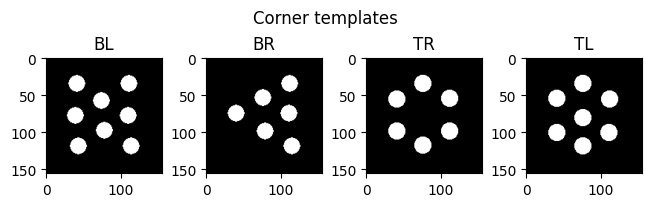

In [5]:
fig, axs = plt.subplots(1, 4, layout='compressed')
fig.suptitle("Corner templates")
for k in range(4):
    axs[k].imshow(corner_templ[sides[k]], cmap='grey')
    axs[k].set_box_aspect(1)
    axs[k].set_title(sides[k])
plt.show()

__2. Read the patches and the WSI__
---

In [6]:
path_to_hires = [ # paths to hires images from Visium
    "../../SpTx/visium/SN123_A551763_Rep1/",
    "../../SpTx/visium/SN123_A595688_Rep1/",
    "../../SpTx/visium/SN123_A798015_Rep1/",
    "../../SpTx/visium/SN123_A938797_Rep1_X/",
]

# path_to_hires = [ # paths to hires images from Visium
#     "../../SpTx/visium/SN124_A551763_Rep2/",
#     "../../SpTx/visium/SN124_A595688_Rep2/",
#     "../../SpTx/visium/SN124_A798015_Rep2/",
#     "../../SpTx/visium/SN124_A938797_Rep2/",
# ]

# WSI name:
wsi_name = "../../SpTx/visium/SN123.ndpi" 
# wsi_name = "../../SpTx/visium/SN124.ndpi" 
wsi_work_mag = 2.5 # 2.5x = 40x/16

# Output/results
dst_folder = "../../SpTx/visium/SN123"
# dst_folder = "../../SpTx/visium/SN124"

dst_names = [ Path(_n).stem for _n in path_to_hires ]

# Options
save_detailed_registration = False

In [7]:
# Read hi-res images as grey scale, extract the corner regions (1/10 of the image size)
himg_names = [ Path(_n) / "hires_image.png" for _n in path_to_hires ]

himgs = {}
gexp_files = {}  # gene expression files
spot_files = {}  # spots
k = 1
for himg_name, dst in zip(himg_names, dst_names):
    himgs[f'himg{k}'] = {}
    himg = cv2.imread(str(himg_name), cv2.IMREAD_GRAYSCALE)
    himgs[f'himg{k}']['image'] = himg.copy()
    himgs[f'himg{k}']['name'] = dst
    himgs[f'himg{k}']['source'] = str(himg_name)

    gexp_files[f'himg{k}'] = himg_name.parent / "expression.feather"
    spot_files[f'himg{k}'] = himg_name.parent / "spots.feather"

    k += 1

Create `phantoms`: arrays with spots centers, that will be subjected to the same transformations
as the _high resolution_ images.

In [8]:
phantoms = {}
for h in himgs:
    phantoms[h] = np.zeros_like(himgs[h]['image'], dtype=np.int32)

And here are the 4 patches:

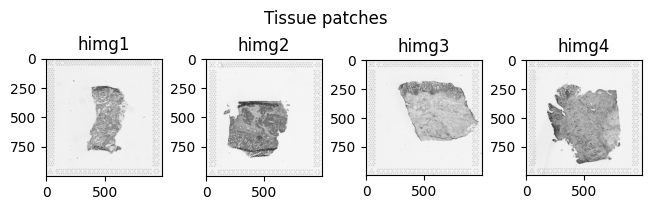

In [9]:
fig, axs = plt.subplots(1, 4, layout='compressed')
fig.suptitle("Tissue patches")
for k in range(4):
    # show them half size
    axs[k].imshow(cv2.resize(himgs[f'himg{k+1}']['image'], None, fx=0.5, fy=0.5), cmap='grey')
    axs[k].set_title(f'himg{k+1}')
plt.show()

The WSI contains 4 regions - we call them 'A', ..., 'D' from left to right:

In [10]:
wsi_slide = WSI(wsi_name)
t_img = wsi_slide.get_plane(wsi_slide.get_level_for_magnification(wsi_work_mag), as_type=np.uint8)
wsi = cv2.cvtColor(t_img, cv2.COLOR_RGB2GRAY)

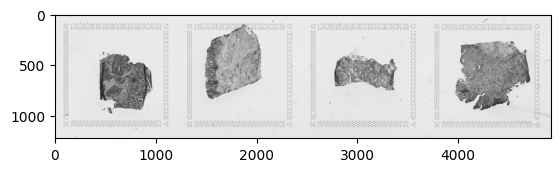

In [11]:
plt.imshow(cv2.resize(wsi, None, fx=0.5, fy=0.5), cmap='grey')

In [12]:
# Split the WSI into 4 parts (A...D):
wsi_h, wsi_w = wsi.shape[:2]
wsi_parts = {
    'A' : wsi[:, 0:wsi_w // 4], 'A_x0': 0, 'A_x1': wsi_w // 4,
    'B' : wsi[:,wsi_w//4:wsi_w//2], 'B_x0': wsi_w//4, 'B_x1': wsi_w // 2,
    'C' : wsi[:,wsi_w//2:3*(wsi_w//4)], 'C_x0': wsi_w//2, 'C_x1': 3*(wsi_w // 4),
    'D' : wsi[:,3*(wsi_w//4):wsi_w], 'D_x0': 3*(wsi_w//4), 'D_x1': wsi_w
}

Check whether the WSI parts are properly separated:

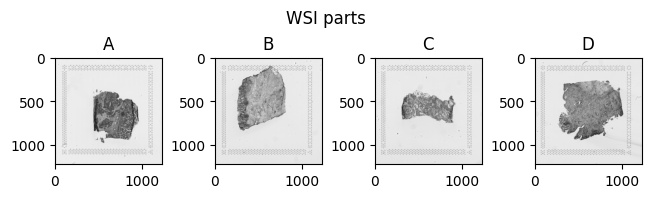

In [13]:
fig, axs = plt.subplots(1, 4, layout='compressed')
fig.suptitle("WSI parts")
k = 0
for p in ['A','B','C','D']:
    # show them half size
    axs[k].imshow(cv2.resize(wsi_parts[p], None, fx=0.5, fy=0.5), cmap='grey')
    axs[k].set_title(p)
    k += 1
plt.show()

__Verify whether the spots fall properly in the high resolution images__

This step helps in confirming that the spot coordinates are correct.

In [14]:
# First, update the phantoms to store the index of the spots at the correspoding spot position
# (i.e. each spot is represented by a disk, with pixel values equal to spot's index + 1).

for hi in himgs:
    spots = pd.read_feather(spot_files[hi])
    s_xy = spots[["x", "y"]].values     # spot centres
    s_rd = spots[["radius"]].values[:,-1] # just a vector
    n_s = s_xy.shape[0]
    for i in range(n_s):
        r, c = draw_disk( (int(s_xy[i,1]), int(s_xy[i,0])), # (row, col)
                          int(s_rd[i]), shape=phantoms[hi].shape )
        phantoms[hi][r, c] = i + 1

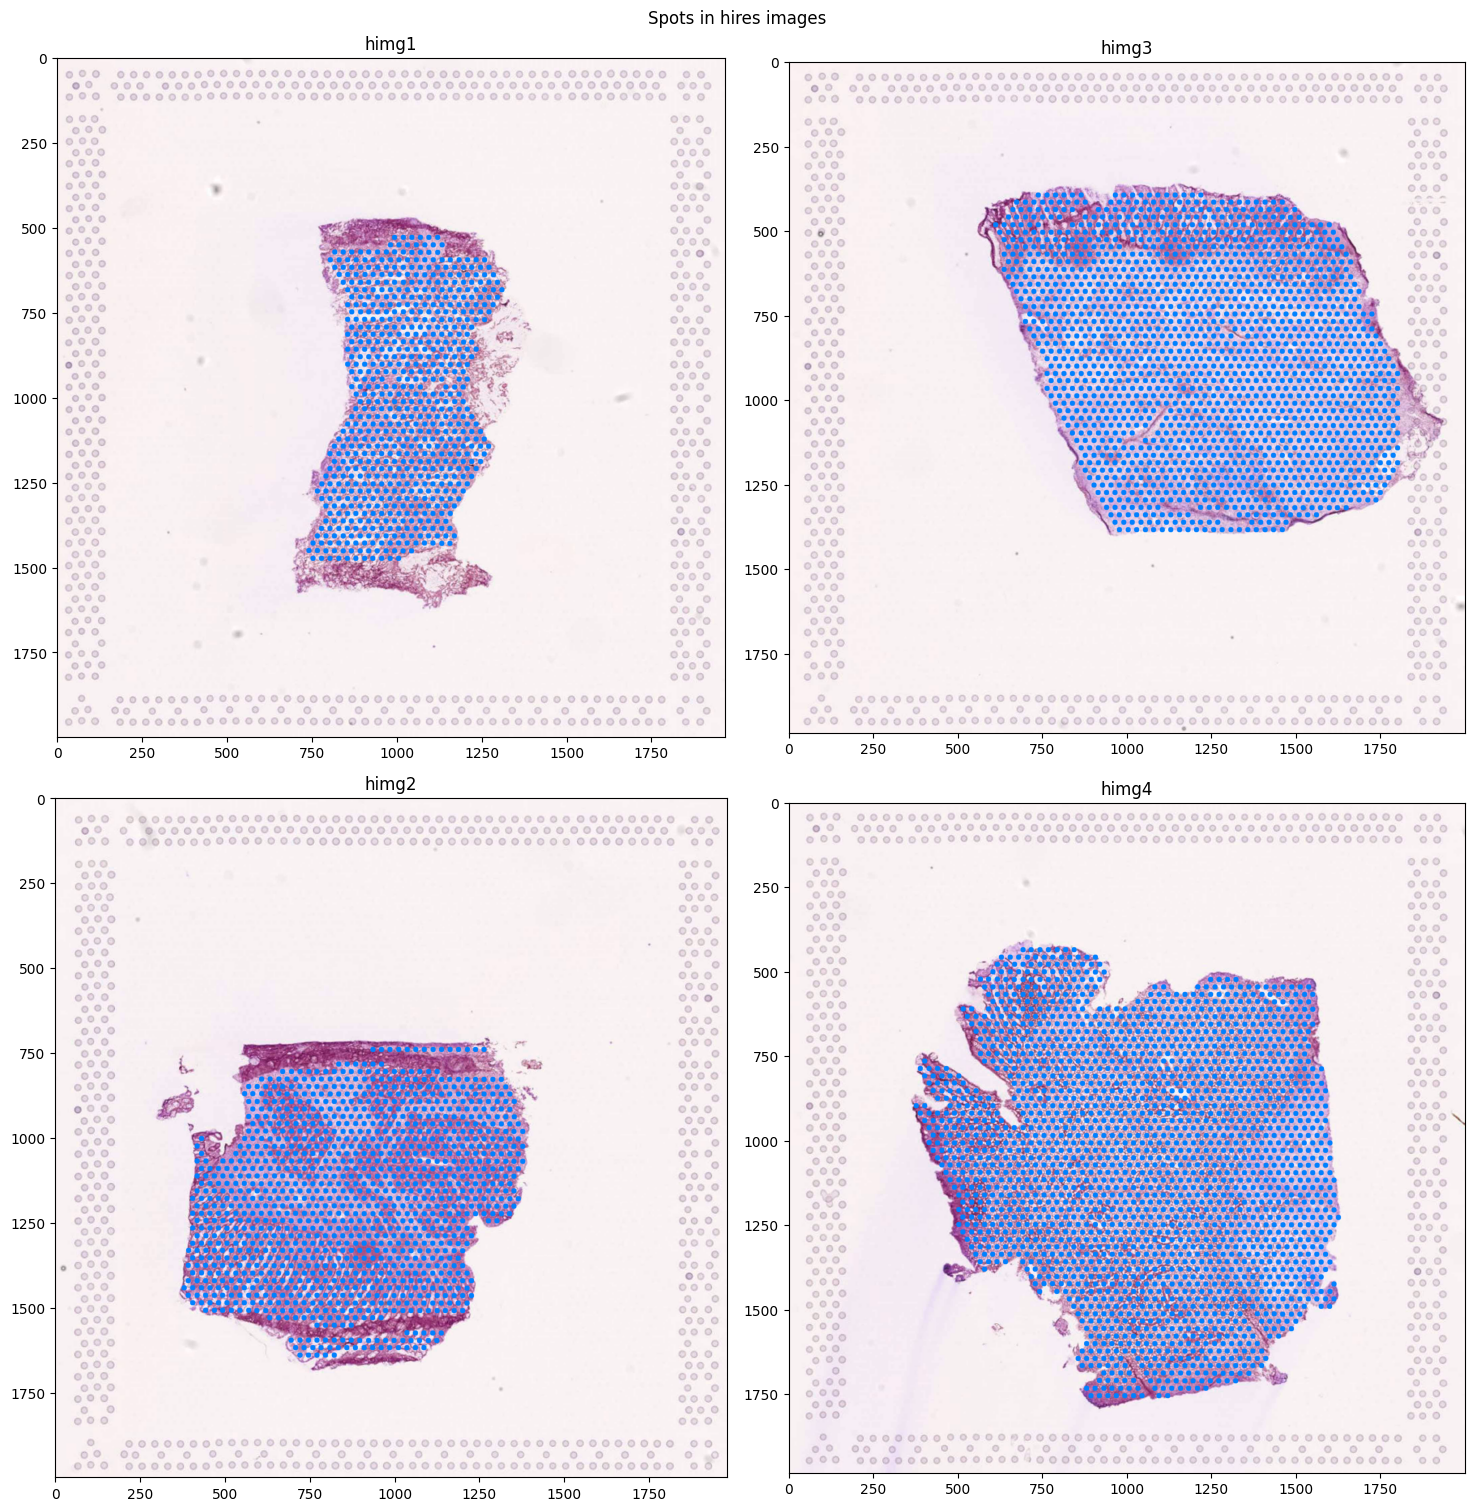

In [15]:
fig, axs = plt.subplots(2, 2, layout='compressed')
fig.suptitle("Spots in hires images")
fig.set_size_inches(15, 15)
k = 0

# Seems like the spot centers are given as (row,column) despite them being called "x" and "y"!!!
for hi in himgs:
    spots = pd.read_feather(spot_files[hi])
    s_xy = spots[["x", "y"]].values    # spot centres
    s_rd = spots[["radius"]].values[:,-1] # just a vector
    n_s = s_xy.shape[0]
    img = cv2.imread(str(himgs[hi]['source']))
    # draw just the circles/spots:
    for i in range(n_s):
        #r, c = circle_perimeter(int(s_xy[i,1]), int(s_xy[i,0]), int(s_rd[i]), shape=img.shape)
        r, c = draw_disk( (int(s_xy[i,1]), int(s_xy[i,0])), # (row, col)
                          int(s_rd[i]), shape=img.shape )
        img[r, c] = (0, 128, 255)
    axs[k % 2][k // 2].imshow(img)
    axs[k % 2][k // 2].set_title(hi)
    k += 1
plt.show()

__3. Label WSI parts' corners__
---

To label the corners of the A, ..., D parts of the WSI, we match the templates and find the common permutation that maps TL, TR,... templates onto the corners of the parts.

In [16]:
# Match corners of the WSI parts with the template corners:
wsi_corner_match = {}
for prt in ['A','B','C','D']:
    part = wsi_parts[prt]
    # get corners for the part:
    part_corners = get_corners(part, n_segm=6)
    # match corners
    wsi_corner_match[prt] = match_templates_to_corners(corner_templ, part_corners, k_list=orientations['0'])

In [17]:
# Find the orientation of each part - they all should be the same
for prt in wsi_corner_match:
    # collect the corner matches, in the order of the template corners (orientations['0'])
    matches = [wsi_corner_match[prt][ts]['corner'] for ts in orientations['0']]
    wsi_corner_match[prt]['orientation'] = -1
    for ornt in orientations:
        if match_lists(matches, orientations[ornt]) >= 3:  # at least 3 corners should match
            wsi_corner_match[prt]['orientation'] = int(ornt)
            break

# get the dominant orientation:
orientations_list = [str(wsi_corner_match[prt]['orientation']) for prt in wsi_corner_match]

if '-1' in orientations_list:
    # some parts have no orientation, which is unexpected, but use the most common anyway:
    dominant_orientation = collections.Counter(orientations_list).most_common(1)[0][0]
    for prt in wsi_corner_match:
        if wsi_corner_match[prt]['orientation'] == -1:
            wsi_corner_match[prt]['orientation'] = int(dominant_orientation)

if len([1 for p in wsi_corner_match if wsi_corner_match[p]['orientation'] == -1]) > 0:
    raise RuntimeError('Cannot establish patch orientation')

In [18]:
for p in wsi_corner_match:
    print(f"Orientation of part {p} is {wsi_corner_match[p]['orientation']}")

Orientation of part A is 0
Orientation of part B is 0
Orientation of part C is 0
Orientation of part D is 0


__4. Label the corners of the hires images__
---

Repeat the same procedure as above, to label the corners of the hires images and estimate the permutation needed to align these images with the orientation of the WSI.

In [19]:
# Match the corners of the hires images with the template corners:
for himg in himgs:
    # preprocess the corners of the hires image:
    corners = get_corners(himgs[himg]['image'], n_segm=8)

    # match corners
    himgs[himg]['corner_match'] = match_templates_to_corners(corner_templ, corners)

In [20]:
# Find the orientation of each patch
for himg in himgs:
    # collect the corner matches, in the order of the template corners (orientations['0'])
    matches = []
    for ts in orientations['0']:
        if himgs[himg]['corner_match'][ts]['match']['score'] >= 0.8:  # allow only good matches
            matches.append(himgs[himg]['corner_match'][ts]['corner'])
        else:
            matches.append(None)
    himgs[himg]['orientation'] = -1
    for ornt in orientations:
        if match_lists(matches, orientations[ornt]) >= 2:  # at least 2 corners should match
            himgs[himg]['orientation'] = int(ornt)
            break

Below are the aligned high resolution images (and the WSI parts for reference):

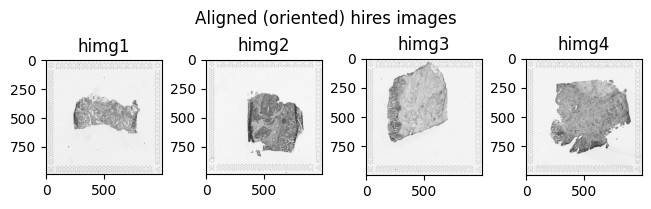

In [21]:
fig, axs = plt.subplots(1, 4, layout='compressed')
fig.suptitle("Aligned (oriented) hires images")
for k, h in enumerate(himgs):
    t_img = cv2.resize(himgs[h]['image'], None, fx=0.5, fy=0.5)  # half size, for drawing
    if himgs[h]['orientation'] != 0:
        # for the rotation codes: we use CCW angles, so 90 deg CCW is the first one, etc
        rc = [cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE][himgs[h]['orientation'] // 90 - 1] # from angle to CV2 rotation code
        t_img = cv2.rotate(t_img, rc)
    axs[k].imshow(t_img, cmap='grey')
    axs[k].set_title(h)
plt.show()

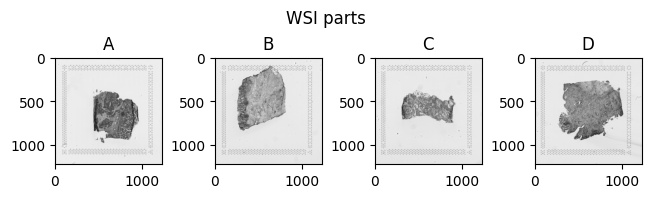

In [22]:
fig, axs = plt.subplots(1, 4, layout='compressed')
fig.suptitle("WSI parts")
k = 0
for p in ['A','B','C','D']:
    # show them half size
    axs[k].imshow(cv2.resize(wsi_parts[p], None, fx=0.5, fy=0.5), cmap='grey')
    axs[k].set_title(p)
    k += 1
plt.show()

__5. Register the high resolution images onto the parts of the WSI__
---

This step will:
- find the best matching part of the WSI for each high resolution image
- compute the corresponding affine transformation

In [23]:
def align_patch(img1: np.array, img2: np.array, 
                resize_factor:float=1.0/8.0,
                min_matching_points: int = 10) -> Union[np.array, None]:
    # Register an image onto the reference image and return the
    # affine transformation as a Numpy array.
    # img1: moving image (2 channels)
    # img2: reference image (2 channels); does not change
    # resize_factor: work resolution for registration
    #
    # returns affine transform H: img2 = img1 * H

    img1_rs = cv2.resize(
        img1,
        (0,0), fx=resize_factor, fy=resize_factor
    )
    img2_rs = cv2.resize(
        img2,
        (0,0), fx=resize_factor, fy=resize_factor
    )

    # Initiate SIFT detector
    sift_detector = cv2.SIFT_create()

    # Find the key points and descriptors with SIFT on the lower resolution images
    kp1, des1 = sift_detector.detectAndCompute(img1_rs, None)
    kp2, des2 = sift_detector.detectAndCompute(img2_rs, None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Filter out poor matches
    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append(m)

    matches = good_matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = kp1[match.queryIdx].pt
        points2[i, :] = kp2[match.trainIdx].pt

    # Find homography
    if points1.shape[0] <= min_matching_points:
        return None
    H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Get low-res and high-res sizes
    low_height, low_width = img1_rs.shape
    height, width = img1.shape
    low_size = np.array(
        [
            [0, 0],
            [0, low_height],
            [low_width, low_height],
            [low_width, 0]
        ], dtype=np.float32
    )
    high_size = np.array(
        [
            [0, 0],
            [0, height],
            [width, height],
            [width, 0]
        ], dtype=np.float32
    )

    # Compute scaling transformations
    scale_up = cv2.getPerspectiveTransform(low_size, high_size)
    scale_down = cv2.getPerspectiveTransform(high_size, low_size)

    # Combine the transformations. Remember that the order of the transformation
    # is reversed when doing matrix multiplication
    # so this is actually scale_down -> H -> scale_up
    h_and_scale_up = np.matmul(scale_up, H)
    scale_down_h_scale_up = np.matmul(h_and_scale_up, scale_down)

    return scale_down_h_scale_up

In [24]:
hires_to_wsi = {}  # for each hires image, stores the mapping to wsi part

for himg in himgs:
    #hires_to_wsi[himg] = {'part': None, 'rotation': None, 'scale': None, 'translation': None, 'affine': None, 'simscore': -1.0}
    hires_to_wsi[himg] = {
        'part': None, 
        'rotation': None, # pre-affine rotation
        'affine': None, 
        'non-rigid': None,
        'simscore': -1.0
    }
    for part in ['A','B','C','D']:    
        h_im = himgs[himg]['image']
        p_im = wsi_parts[part]
        
        # 0. prepare - use the initial estimate of the rotation:
        if himgs[himg]['orientation'] != 0:
            # for the rotation codes: we use CCW angles, so 90 deg CCW is the first one, etc
            rc = [cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE][himgs[himg]['orientation'] // 90 - 1] # from angle to CV2 rotation code
            h_im = cv2.rotate(h_im, rc)
            
        # 1. match the histograms
        h_im = np.floor(match_histograms(h_im, p_im)).astype(np.uint8)

        # 2. compute affine transform...
        H = align_patch(h_im, p_im, resize_factor=0.5)
        # ...and transform high res image:
        h2_im = cv2.warpPerspective( h_im, H, (p_im.shape[1], p_im.shape[0]) )

        # 3. compute similarity score
        ssim_score = structural_similarity(p_im, h2_im, win_size=35, full=False)

        if ssim_score > hires_to_wsi[himg]['simscore']:
            hires_to_wsi[himg].update(
                {
                    'part': part,
                    'rotation': himgs[himg]['orientation'],
                    'affine': H,
                    'simscore': ssim_score,
                    'timg': h2_im,
                }
            )
# apply the same transformations to the phantoms:
for hi in himgs:
    if hires_to_wsi[hi]['rotation'] != 0:
        r = hires_to_wsi[hi]['rotation'] // 90 - 1  # 0, 1, 2
        rc = [cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE][r] # from angle to CV2 rotation code
        phantoms[hi] = cv2.rotate(phantoms[hi], rc) # apply the same to the phantom
    H = hires_to_wsi[hi]['affine']
    p_im = wsi_parts[hires_to_wsi[hi]['part']]
    phantoms[hi] = cv2.warpPerspective( phantoms[hi], H, (p_im.shape[1], p_im.shape[0]), 
                                        flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0 )

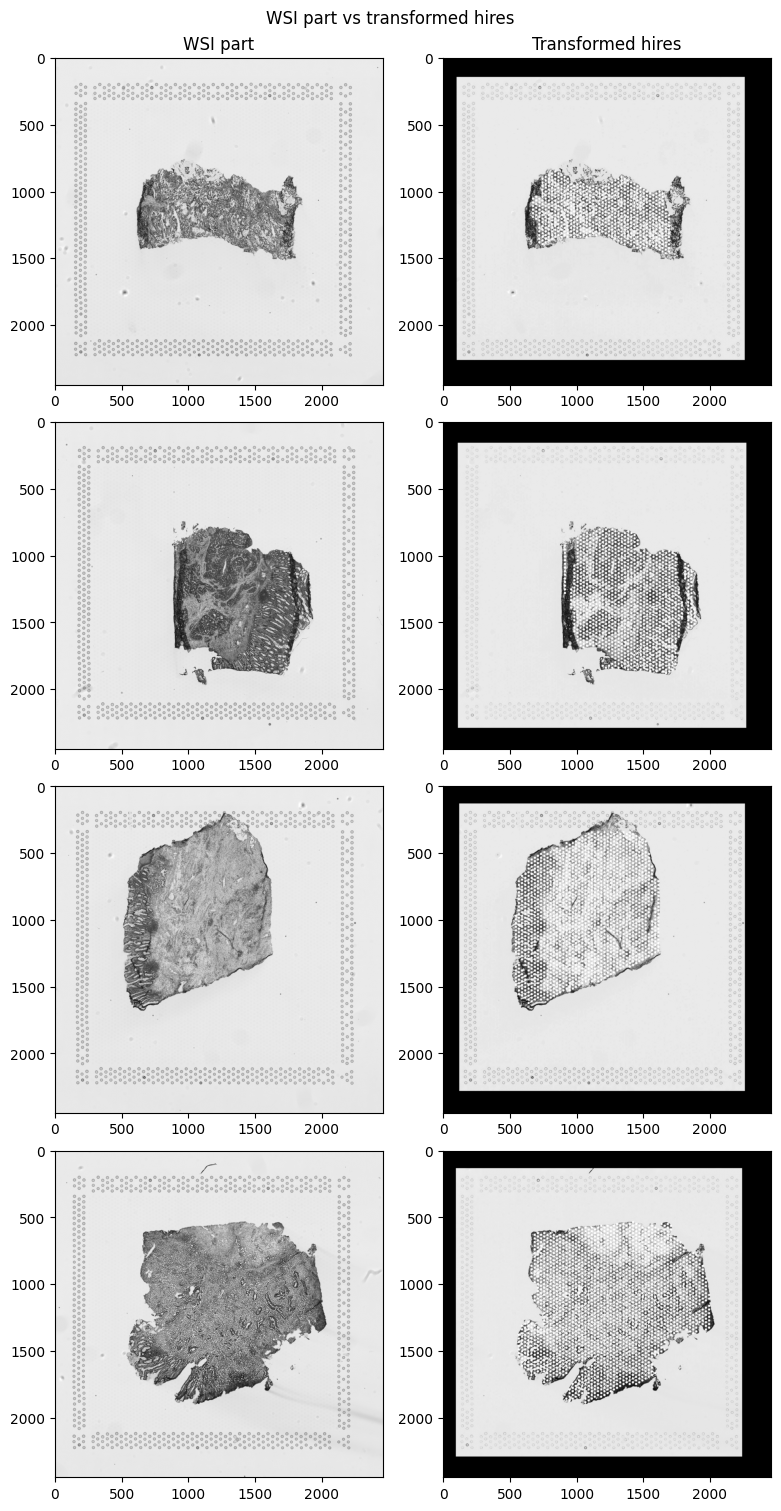

In [25]:
fig, axs = plt.subplots(4, 2, layout='compressed')
fig.suptitle("WSI part vs transformed hires")
fig.set_size_inches(15, 15)

for  k, kk in enumerate(hires_to_wsi):
    #p_im = cv2.resize(wsi_parts[hires_to_wsi[kk]['part']], None, fx=0.5, fy=0.5)
    p_im = wsi_parts[hires_to_wsi[kk]['part']]
    axs[k, 0].imshow(p_im, cmap='grey')
    timg = hires_to_wsi[kk]['timg']
    timg[phantoms[kk] > 0] = 255
    axs[k, 1].imshow(timg, cmap='grey')
    if k == 0:
        axs[k, 0].set_title("WSI part")
        axs[k, 1].set_title("Transformed hires")

plt.show()

__6. Write the results__
---

The parts of the WSI are saved as separate pyramidal images (stored as HDF5 - see the [COMPASS package](https://github.com/vladpopovici/compass)). The computed affine transformation is used to map the coordinates of the spots from the "high resolution" image coordinates to the corresponding pyramidal image coordinates. The spots are stored as image annotations (each one as a "Circle" object) with gene expression profile as corresponding metadata - see the [WSITK-annot package](https://github.com/vladpopovici/wsitk-annot).

In [52]:
wsi_slide = WSI(wsi_name)
wsi_shape = wsi_slide.shape(level=0)
work_level = wsi_slide.get_level_for_magnification(wsi_work_mag)

for hi in himgs:
    mgr = SampleManager(dst_folder, himgs[hi]['name'], mode="w", overwrite_if_exists=True)

    part_name = hires_to_wsi[hi]['part']
    pp = wsi_slide.convert_px(
        Px(x=wsi_parts[part_name+'_x0'], y=0),
        from_level=work_level,
        to_level=0
    )
    x0 = pp.x
    pp = wsi_slide.convert_px(
        Px(x=wsi_parts[part_name+'_x1'], y=0),
        from_level=work_level,
        to_level=0
    )
    x1 = pp.x
    # write the ROI from WSI into a pyramidal HDF5:
    wsi2hdf5(wsi_name, mgr.get_pyramid_path(0), crop=(x0, 0, x1-x0, wsi_shape.height))

    if save_detailed_registration:
        # Save high-res transformed image and the corresponding region of WSI
        tmp_part_img = wsi_parts[hires_to_wsi[hi]['part']]
        tmp_img = cv2.imread(str(himgs[hi]['source']))
        if himgs[hi]['orientation'] != 0:
            # for the rotation codes: we use CCW angles, so 90 deg CCW is the first one, etc
            rc = [cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE][himgs[hi]['orientation'] // 90 - 1] # from angle to CV2 rotation code
            tmp_img = cv2.rotate(tmp_img, rc)
        tmp_img_t = cv2.warpPerspective( 
            tmp_img, 
            hires_to_wsi[hi]['affine'],
            (tmp_part_img.shape[1], tmp_part_img.shape[0]) 
        )
        cv2.imwrite(f"{str(mgr.full_path)}/hires-{hi}.png", tmp_img_t)  # hires_to_wsi[hi]['timg'])
    
        tmp_img = wsi_slide.get_plane(wsi_slide.get_level_for_magnification(wsi_work_mag), as_type=np.uint8)
        tmp_part = hires_to_wsi[hi]['part']
        tmp_part_x0 = wsi_parts[f"{tmp_part}_x0"]
        tmp_part_x1 = wsi_parts[f"{tmp_part}_x1"]
        tmp_img = tmp_img[:,tmp_part_x0:tmp_part_x1,:]
        cv2.imwrite(f"{str(mgr.full_path)}/wsi_part-{tmp_part}-for_{hi}.png", tmp_img)
        
        # save transformation:
        with open(mgr.full_path / "transformation_from_hires.json", "wb") as f:
            dict_to_write = {
                'part': hires_to_wsi[hi]['part'],
                'rotation': hires_to_wsi[hi]['rotation'],
                'affine': hires_to_wsi[hi]['affine'],
                'simscore': hires_to_wsi[hi]['simscore'],
            } # do not save the transformed image
            f.write(
                json.dumps(
                    dict_to_write,
                    option=json.OPT_NON_STR_KEYS | json.OPT_INDENT_2 | json.OPT_SERIALIZE_NUMPY
                )
            )
    

    # process annotations (spots and gene expression)
    expr_data = pd.read_feather(gexp_files[hi])
    spots = pd.read_feather(spot_files[hi])
    n_spots = spots.shape[0]
    
    # get the spots positions from the phantom images
    spots_props = regionprops(phantoms[hi])
        
    s_xy_t = np.zeros( (phantoms[hi].max(), 2), dtype=np.int32 ) - 1 # new spot coords; "-1" flags not initialized
    s_rd_t = np.zeros( (phantoms[hi].max(),), dtype=np.int32 ) - 1   # new radius
    for pr in spots_props:
        l    = pr.label - 1  # spot index starts at 0
        rd   = int( pr.equivalent_diameter_area / 2 )  
        r, c = pr.centroid
        s_xy_t[l,] = [c, r]
        s_rd_t[l]  = rd

    # create the annotation:
    mri = MRI(mgr.get_pyramid_path(0))
    w, h = mri.extent(work_level)
    annot = wsitk_annot.Annotation(
        name="transcriptomics",
        image_shape={'width': w, 'height': h},
        # the initial mpp is at the work_level level:
        mpp = mri.get_mpp_for_level(work_level)
    )
    # Create the corresponding annotations
    genes = expr_data.apply(lambda row: row[row > 0].index.tolist(), axis=1) # detected genes, for each spot (list of lists)

    s_idx = np.where(s_rd_t >= 0)[0]  # get idx of mapped spots
    print(f"No. of re-mapped spots: {len(s_idx)} out of {n_spots}.")
    for k in s_idx:
        annot.add_annotation_object(
            wsitk_annot.Circle((s_xy_t[k,0], s_xy_t[k,1]), # (x,y)
                               s_rd_t[k],
                               name=f"spot_{k}",
                               data=expr_data.loc[k, genes[k]].tolist())
        )

    # bring annotation to the highest mpp
    annot.set_resolution(mri.get_mpp_for_level(0))

    # save the annotation
    mgr.add_annotation(annot, 0, "Visium spots")

No. of re-mapped spots: 1219 out of 1219.
No. of re-mapped spots: 387 out of 387.
No. of re-mapped spots: 1656 out of 1656.
No. of re-mapped spots: 1691 out of 1691.


__7. Verification__
---

Display low resolution images with spots computed from the annotation.

In [53]:
import gzip

v_imgs = {}  # named list with resulting images
v_level = 5  # level for showing the results

for hi in himgs:
    mri_path = (Path(dst_folder) / himgs[hi]['name']).with_suffix('.cp') / 'pyramid_0.h5'

    # image:
    mri = MRI(mri_path)
    img = np.array( mri.get_plane(v_level , as_type=np.uint8) )

    # annotation
    annot_file = (Path(dst_folder) / himgs[hi]['name']).with_suffix('.cp') / 'annot_0.json.gz'  # annotation for master pyramid (0)
    annot = wsitk_annot.Annotation()
    with gzip.open(annot_file, 'rb') as f:
        annot.load(f)
    # bring annotation to required pyramid level:
    annot.set_resolution( mri.get_mpp_for_level(v_level) )

    # draw just the circles/spots:
    for a in annot._annots['base']:
        if a._annotation_type != "CIRCLE":
            continue
        r, c = draw_disk( ( int(a.center[1]), int(a.center[0]) ), # (row, col), not (x,y)
                          int(a.radius), shape=img.shape )
        img[r, c] = (0, 128, 255)
        v_imgs[hi] = img

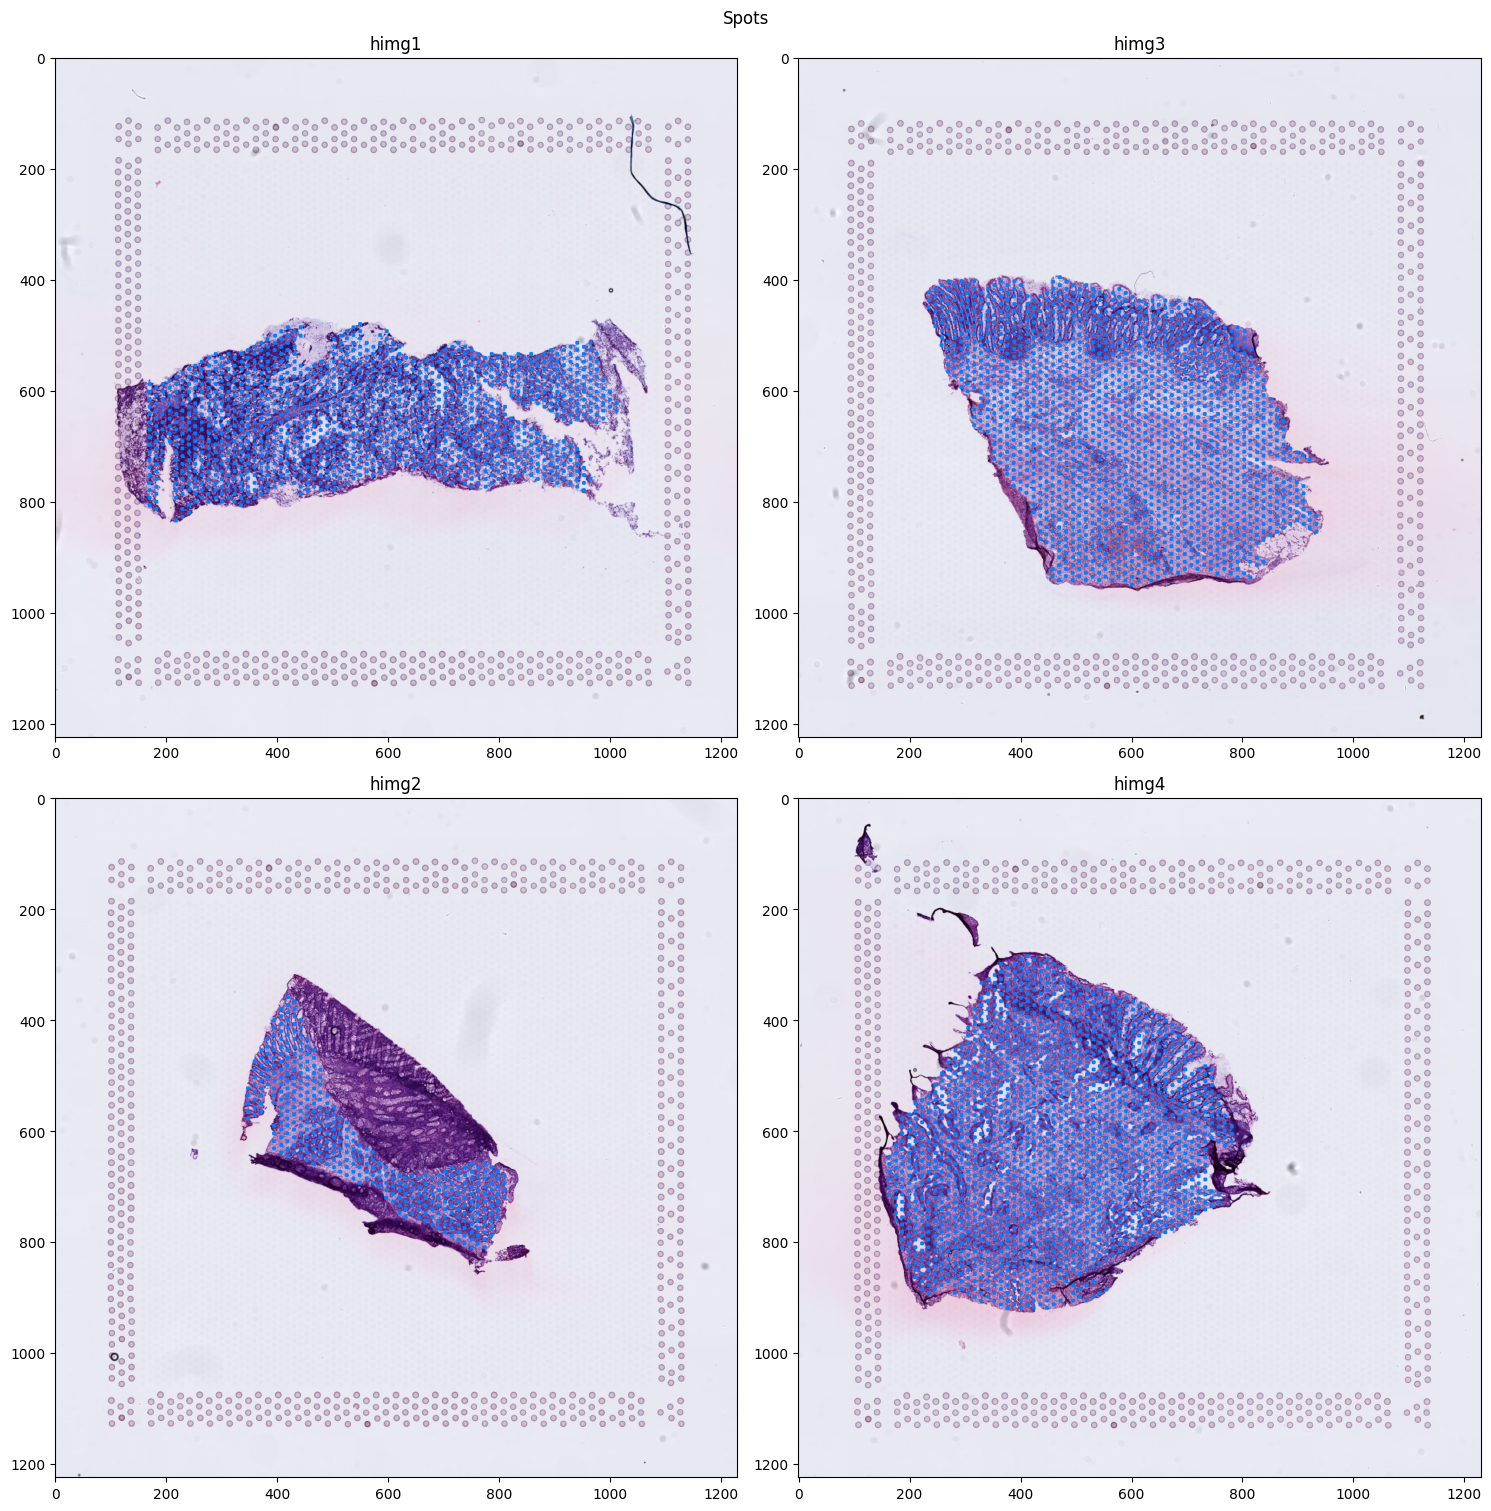

In [54]:
fig, axs = plt.subplots(2, 2, layout='compressed')
fig.suptitle("Spots")
fig.set_size_inches(15, 15)
k = 0
for im in v_imgs:
    # show them half size
    axs[k % 2][k // 2].imshow(v_imgs[im])
    axs[k % 2][k // 2].set_title(im)
    k += 1
plt.show()